# Part 2 Sentence-Level Categorization: Question Classification

Import all relevant libraries


In [ ]:
import gensim.downloader
import numpy as np
import pandas as pd
import tqdm
import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt

# Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

## Let us first pre-process the dataset, and create a development set


In [ ]:
# Create a seed for reproducibility
random_seed = 11

### Create train_df,validation_df and test_df, where validation_df has 500 examples extracted from original_train_df

In [ ]:
# Define the file paths
train_file = "data/Part 2/train.csv"
test_file = "data/Part 2/test.csv"

# Load the original training data
original_train_df = pd.read_csv(train_file)

# Split the original training data into train and validation sets
train_df, validation_df = train_test_split(original_train_df, test_size=500, random_state=random_seed)

# Load the test data
test_df = pd.read_csv(test_file)

In [ ]:
print("Original shape:   ", original_train_df.shape)
print("Training shape:   ", train_df.shape)
print("Validation shape: ", validation_df.shape)
print("Test shape:\t  ", test_df.shape)

Original shape:    (5452, 3)
Training shape:    (4952, 3)
Validation shape:  (500, 3)
Test shape:	   (500, 3)


### Randomly select 4 class from the 6 different coarse labels and combine the remaing labels to form a single class 'OTHERS'


In [ ]:
# Column name   	 Description
# label-coarse  	 The coarse-grained label for the question. (String)
# label-fine    	 The fine-grained label for the question. (String)
# text          	 The text of the question. (String)
# We will be focusing on the label-coarse, to use RNNs approach for classification of question labels.
train_df

,label-coarse,label-fine,text
483,3,4,"Who came up with the name , El Nino ?"
2237,5,14,What river is Pocahontas buried along ?
605,1,19,What color of dry wine should be served with v...
2026,4,13,What is the population in India ?
1478,3,4,Who won the 1967 Academy Award for Best Actor ?
...,...,...,...
1293,5,24,What is the world 's highest peak ?
4023,3,4,What Batman character tools around on a Batcyc...
5200,1,10,What are some science fair projects for 8th gr...
3775,0,0,How does food color affect how you think it wi...


In [ ]:
train_df['label-coarse'].value_counts()

label-coarse
1    1139
3    1111
0    1049
4     821
5     753
2      79
Name: count, dtype: int64

In [ ]:
# Define the original classes
original_classes = train_df['label-coarse'].unique()
print(original_classes)

# Randomly select 4 classes from the original classes
rng = np.random.default_rng(seed=random_seed)
selected_classes = rng.choice(original_classes, size=4, replace=False)
print('Selected classes:', selected_classes)
not_selected_classes = [c for c in original_classes if c not in selected_classes]
print('Not selected classes:', not_selected_classes)

''' For training data '''
# Combine the remaining classes into 'OTHERS'
train_df['label-coarse'] = train_df['label-coarse'].astype('object')
train_df.loc[~train_df['label-coarse'].isin(selected_classes), 'label-coarse'] = 'OTHERS'
print(train_df['label-coarse'].value_counts())

''' For validation data '''
# Combine the remaining classes into 'OTHERS'
validation_df['label-coarse'] = validation_df['label-coarse'].astype('object')
validation_df.loc[~validation_df['label-coarse'].isin(selected_classes), 'label-coarse'] = 'OTHERS'
print(validation_df['label-coarse'].value_counts())

''' For test data '''
# Combine the remaining classes into 'OTHERS'
test_df['label-coarse'] = test_df['label-coarse'].astype('object')
test_df.loc[~test_df['label-coarse'].isin(selected_classes),'label-coarse'] = 'OTHERS'
print(test_df['label-coarse'].value_counts())

[3 5 1 4 0 2]
Selected classes: [3 1 4 0]
Not selected classes: [5, 2]
label-coarse
1         1139
3         1111
0         1049
OTHERS     832
4          821
Name: count, dtype: int64
label-coarse
0         113
3         112
1         111
OTHERS     89
4          75
Name: count, dtype: int64
label-coarse
0         138
4         113
1          94
OTHERS     90
3          65
Name: count, dtype: int64


In [ ]:
train_df.dtypes

label-coarse    object
label-fine       int64
text            object
dtype: object

In [ ]:
# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


(a) So we define the 5 classes that we are using to be [1,3,0,'OTHERS',4] and they are mapped to their indexes in this list, we get the dictionary of {1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}

## Design of the Neural Network

### Append a zero vector to w2v to handle paddings


In [ ]:
pretrained_embeddings = torch.FloatTensor(np.append(w2v.vectors, [np.zeros((300,))], axis=0))

### Defining the data loaders and preprocessing of data


In [ ]:
# Set a specific random seed for reproducibility.
torch.manual_seed(random_seed)


class QuestionDataset(Dataset):
    '''Custom dataset class to load data into DataLoader
    Init Arguments:
        x: array[][int], contains the index of the word in the sentence mapped to the word embedding
        y: array[int], contains the index of the coarse-label of the sentences
        s_len: array[int], contains the length of the sentence

    '''
    def __init__(self, x, y, s_len):
        self.x = x
        self.y = y
        self.s_len = s_len

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.s_len[idx]

def preprocess_data(df, w2v_model):
    ''' Preprocessing the data and returning tokenized sentences filtered off by stop words.
    Returns:
        sentences: tensor[][int], contains the index of the word in the sentence mapped to the word embedding
        labels: tensor[int], contains the index of the coarse-label of the sentences
        sentence_lengths: tensor[int], contains the length of the sentence
    '''
    sentences = []
    labels = []
    sentence_lengths = []

    for index, row in df.iterrows():
        word_to_index = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else 3000000 for word in row['text'].split()]
        sentences.append(word_to_index)
        labels.append(labels_dict[row['label-coarse']])

    count_of_sentence_lengths = defaultdict(int)
    for row in sentences:
        count_of_sentence_lengths[len(row)] += 1
    max_sentence_len = max(count_of_sentence_lengths)

    for idx, row in enumerate(sentences):
        sentence_lengths.append(len(row))
        if len(row) != max_sentence_len:
            num_padding = max_sentence_len - len(row)
            sentences[idx] += [3000000] * num_padding

    return torch.tensor(sentences), torch.tensor(labels, dtype=torch.long), sentence_lengths


def get_training_data(batch_size, w2v_model, train_df, validation_df, random_seed=random_seed):
    ''' Getting the training and validation data
    Returns:
        train_data_loader: DataLoader, contains the training data
        validation_data_loader: DataLoader, contains the validation data
    '''
    x_train, y_train, train_seq_len = preprocess_data(train_df, w2v_model)
    train_dataset = QuestionDataset(x_train, y_train, train_seq_len)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    x_validation, y_validation, validate_seq_len = preprocess_data(
        validation_df, w2v_model)
    validation_dataset = QuestionDataset(
        x_validation, y_validation, validate_seq_len)
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size,
                                        shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    return train_data_loader, validation_data_loader


def get_test_data(batch_size, w2v_model, random_seed=random_seed):
    ''' Getting the test data
    Returns:
        test_data_loader: DataLoader, contains the test data
    '''
    x_test, y_test, test_seq_len = preprocess_data(test_df, w2v_model)
    test_dataset = QuestionDataset(x_test, y_test, test_seq_len)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    return test_data_loader

### Defining the Neural Network
forward() has a parameter which allows us to specify which aggregation mode to use, etc mode, mean, rnn, rnnmulti

(c) The neural network is described here, using LSTM to produce the final vector representation of each word and the mathematical functions used for the forward computation are under mode == 'mean' since we're using mean aggregation.

In [ ]:
class QuestionModel(nn.Module):
    ''' Neural Network model for classifying questions into coarse labels
    Init Arguments:
        embedding_dim: int, the dimension of the word embedding
        hidden_dim: int, the dimension of the hidden state of the LSTM
        num_labels: int, the number of coarse labels (classes)
        pretrained_embeddings: torch.FloatTensor, the pretrained embeddings from word2vec
        dropout_prob: float, the dropout probability for the dropout layer
    '''
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(QuestionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.map_to_embedding_dim = nn.Linear(hidden_dim, embedding_dim)
        self.multihead_attention = nn.MultiheadAttention(embedding_dim, num_heads=10)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, sentence_len=None, mode=None, random_initial_state=False, _device="cuda"):
        '''Inputs representation:
            x: tozenized sentences,
            mode: "max" pooling, "mean" pooling, "rnn", "rnnmulti" for computing sentence vector representation,
            random_initial_state: whether to use random initial state, h0 and c0, for the LSTM
            _device: device to use for computation, "cuda" or "cpu", default is "cuda"
        '''
        # Convert indices to their word vector representations
        word_vectors = self.embedding(x)

        _vectors = []
        if mode == 'mean':
            # Obtaining the mean of word vectors for each sentence using the mask of the actual sentence length before padded.
            for idx, s in enumerate(word_vectors):
                _vectors.append(torch.mean(s[:sentence_len[idx]], dim=0))
            _vectors = torch.stack(_vectors).unsqueeze(1)
        elif mode == 'max':
            # Obtaining the max vector representation of each sentence
            _vectors, _ = torch.max(word_vectors, dim=1)
            _vectors = _vectors.unsqueeze(1)
        elif mode == 'rnn':
            # Use the RNN to aggregate the word vectors into a sentence representation
            rnn_out, _ = self.rnn(word_vectors)
            # Use the final hidden state of the RNN as the sentence representation
            _vectors = rnn_out[:, -1, :]
            _vectors = self.map_to_embedding_dim(_vectors)
            _vectors = _vectors.unsqueeze(1)
        elif mode == 'rnnmulti':
            rnn_out, _ = self.rnn(word_vectors)
            rnn_out = self.map_to_embedding_dim(rnn_out)  # Map to embedding_dim
            rnn_out = rnn_out.permute(1, 0, 2)  # MultiheadAttention requires [seq_len, batch_size, embedding_dim]
            attn_output, _ = self.multihead_attention(rnn_out, rnn_out, rnn_out)
            attn_output = attn_output.permute(1, 0, 2)  # Back to [batch_size, seq_len, embedding_dim]
            attn_output = attn_output.mean(dim=1)  # Average over the sequence length
            _vectors = attn_output.unsqueeze(1)
        else:
            raise ValueError("mode not called!")

        vectors_tensor = _vectors

        if random_initial_state:
            h0 = torch.randn(1, x.size(0), self.hidden_dim).to(_device)
            c0 = torch.randn(1, x.size(0), self.hidden_dim).to(_device)
            lstm_out, _ = self.lstm(vectors_tensor, (h0, c0))
        else:
            lstm_out, _ = self.lstm(vectors_tensor)

        logits = self.linear(lstm_out.squeeze(1))
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

### Defining Early Stopper and utility functions for getting model and device

In [ ]:
class EarlyStopper:
    '''Early stops the training if validation loss doesn't improve after a given patience.
    
    '''
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_accuracy_ = 0

    def early_stop(self, accuracy_):
        '''Returns True if the validation loss did not improve after patience number of epochs.'''
        if accuracy_ > self.min_accuracy_:
            self.min_accuracy_ = accuracy_
            self.counter = 0
        elif accuracy_ < (self.min_accuracy_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
    '''Returns the model.'''
    return QuestionModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob)

def get_device():
    '''Returns the device to use for computation.'''
    if torch.cuda.is_available():
        print("$ GPU Activated $")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Defining the train_model and test_model functions

In [ ]:
def train_model(model, train_data_loader, validation_data_loader, mode, device, epochs=50,
                random_initial_state=False, learning_rate=0.001, weights=None, early_stopper=None, debug=True):
    '''Trains the model.
    Returns:
        train_accuracies: list[float], contains the training accuracy for each epoch
        validation_accuracies: list[float], contains the validation accuracy for each epoch
        train_losses: list[float], contains the training loss for each epoch
        validation_losses: list[float], contains the validation loss for each epoch
        time_taken: float, the time taken for the model to run finish
    '''
    # Lists to store train and test accuracies and losses
    train_accuracies, validation_accuracies = [], []
    train_losses, validation_losses = [], []

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    model = model.to(device)

    # Record the start time
    start_time = time.time()

    # Training loop
    for epoch in tqdm.tqdm(range(epochs)):
        # =======================Training=======================
        model.train()
        train_loss = 0.0
        total_train, correct_train = 0, 0
        for idx, batch in enumerate(train_data_loader):
            batch_data, batch_labels, train_sentence_len = batch
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()

            outputs = model(batch_data, sentence_len=train_sentence_len, mode=mode,
                            random_initial_state=random_initial_state,
                            _device=device)

            loss = loss_fn(outputs.view(-1, outputs.size(-1)),
                           batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate train accuracy
            predicted = torch.argmax(outputs, dim=1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()
            del batch_data, batch_labels
            torch.cuda.empty_cache()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        # Store train loss
        train_losses.append(train_loss / len(train_data_loader))

    # =======================Validation=======================
        model.eval()
        val_loss = 0.0
        correct_validation, total_validation = 0, 0

        with torch.no_grad():
            for batch_data, batch_labels, val_sentence_len in validation_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data, sentence_len=val_sentence_len, mode=mode, _device=device)
                loss = loss_fn(outputs.view(-1, outputs.size(-1)),batch_labels.view(-1))
                val_loss += loss.item()

                # Calculate test accuracy
                predicted = torch.argmax(outputs, dim=1)
                total_validation += batch_labels.size(0)
                correct_validation += (predicted == batch_labels).sum().item()

        validation_accuracy = correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(
            val_loss / len(validation_data_loader))  # Store test loss

        # Print epoch results
        if debug:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

        # Check for early stopping
        if early_stopper and early_stopper.early_stop(validation_accuracy):
            print(f"Early stopping at epoch ({epoch+1}) due to no improvement in accuracy.")
            break

    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    torch.cuda.empty_cache()  # Release cache
    return train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken

def test_model(model, test_data_loader, mode, device):
    '''Tests the model.
    Returns:
        predicted_labels: list[int], contains the predicted labels for the test data
        actual_labels: list[int], contains the actual labels for the test data
        test_accuracy: float, the test accuracy
    '''
    model = model.to(device)
    model.eval()
    # Variables to track accuracy
    correct_test, total_test = 0, 0
    # Lists to store predicted and actual labels
    predicted_labels = []
    actual_labels = []

    # Record the start time
    start_time = time.time()
    # =======================Testing=======================
    with torch.no_grad():
        for batch_data, batch_labels, test_sentence_len in test_data_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data, sentence_len=test_sentence_len, mode=mode, _device=device)

            # Calculate test accuracy
            predicted = torch.argmax(outputs, dim=1)
            total_test += batch_labels.size(0)
            correct_test += (predicted == batch_labels).sum().item()

            # Append predicted and actual labels to the lists
            predicted_labels.extend(predicted.tolist())
            actual_labels.extend(batch_labels.tolist())

    time_taken = time.time() - start_time

    test_accuracy = correct_test / total_test
    print(f"Time taken to run finish the test: {time_taken:.2f} seconds")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    torch.cuda.empty_cache()  # Release cache
    return predicted_labels, actual_labels, test_accuracy

### Defining a graph plotter function


In [ ]:
def plot_findings(X_axis: list, Y_axis: list, X_label: str, Y_labels: list = ["Accuracy", "Time Taken To Train Model(Seconds)"], isoptimal=False):
    '''Plots the findings.
    Args:
        X_axis: list, contains the values for the x-axis
        Y_axis: list[list], contains the values for the y-axis
        X_label: str, the label for the x-axis
        Y_labels: list[str], the labels for the y-axis
        isoptimal: bool, whether to plot the optimal graph or not
    '''
    plt.figure(figsize=(10, 4))
    color = ['r', 'g', 'b']

    if not isoptimal:
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.plot(range(len(X_axis)), Y_axis[i], marker='o',
                     linestyle='-', color=color[i], label=Y_labels[i])
            plt.xticks(range(len(X_axis)), X_axis)
            plt.xlabel(X_label)
            plt.ylabel(Y_labels[i])
            plt.title(f'{Y_labels[i]} vs. {X_label}')
            plt.grid(True)
            plt.legend()
    else:
        optimal_labels = [["Train_accuracy", "Validation_accuracy"], [
            "Train_losses", "Validation_losses"]]
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.plot(range(1, X_axis+1),
                     Y_axis[i][0], color='r', label=optimal_labels[i][0])
            plt.plot(range(1, X_axis+1),
                     Y_axis[i][1], color='g', label=optimal_labels[i][1])
            Y_labels = ["accuracy", "losses"]
            plt.xlabel(X_label)
            plt.ylabel(Y_labels[i])
            plt.title(f'{Y_labels[i]} vs. {X_label}')
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.grid(True)
    plt.show()

### [Optimal] Here are the results from our optimal paramters


In [ ]:
# # TO FIND OPTIMAL PARAMETERS
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)

$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


In [ ]:
model = get_model(embedding_dim, hidden_dim, num_labels,
                  pretrained_embeddings, dropout_prob=dropout_prob)

# Train the model
train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken = train_model(
    model=model, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    mode=mode, device=device, epochs=epoch, random_initial_state=False, learning_rate=learning_rate,
    early_stopper=early_stopper, debug=True)

# Obtain the accuracy of the model using test set
_, _, test_accuracy = test_model(
    model=model, test_data_loader=test_data_loader, mode=mode, device=device)

  2%|▏         | 1/50 [00:00<00:18,  2.63it/s]

Epoch 1/50, Train Loss: 1.5956, Val Loss: 1.5666, Train Accuracy: 0.3279, Validation Accuracy: 0.4300


  4%|▍         | 2/50 [00:00<00:18,  2.59it/s]

Epoch 2/50, Train Loss: 1.5215, Val Loss: 1.4574, Train Accuracy: 0.3661, Validation Accuracy: 0.4400


  6%|▌         | 3/50 [00:01<00:19,  2.42it/s]

Epoch 3/50, Train Loss: 1.4365, Val Loss: 1.3511, Train Accuracy: 0.4964, Validation Accuracy: 0.6680


  8%|▊         | 4/50 [00:01<00:19,  2.42it/s]

Epoch 4/50, Train Loss: 1.3571, Val Loss: 1.2649, Train Accuracy: 0.5668, Validation Accuracy: 0.7040


 10%|█         | 5/50 [00:01<00:17,  2.56it/s]

Epoch 5/50, Train Loss: 1.3052, Val Loss: 1.2286, Train Accuracy: 0.6149, Validation Accuracy: 0.7260


 12%|█▏        | 6/50 [00:02<00:17,  2.55it/s]

Epoch 6/50, Train Loss: 1.2757, Val Loss: 1.2078, Train Accuracy: 0.6357, Validation Accuracy: 0.7360


 14%|█▍        | 7/50 [00:02<00:16,  2.60it/s]

Epoch 7/50, Train Loss: 1.2552, Val Loss: 1.1917, Train Accuracy: 0.6694, Validation Accuracy: 0.7500


 16%|█▌        | 8/50 [00:03<00:17,  2.46it/s]

Epoch 8/50, Train Loss: 1.2327, Val Loss: 1.1784, Train Accuracy: 0.6906, Validation Accuracy: 0.7640


 18%|█▊        | 9/50 [00:03<00:17,  2.39it/s]

Epoch 9/50, Train Loss: 1.2251, Val Loss: 1.1723, Train Accuracy: 0.6949, Validation Accuracy: 0.7440


 20%|██        | 10/50 [00:04<00:16,  2.38it/s]

Epoch 10/50, Train Loss: 1.2127, Val Loss: 1.1631, Train Accuracy: 0.7126, Validation Accuracy: 0.7560


 22%|██▏       | 11/50 [00:04<00:16,  2.38it/s]

Epoch 11/50, Train Loss: 1.2028, Val Loss: 1.1569, Train Accuracy: 0.7191, Validation Accuracy: 0.7680


 24%|██▍       | 12/50 [00:04<00:15,  2.38it/s]

Epoch 12/50, Train Loss: 1.1991, Val Loss: 1.1540, Train Accuracy: 0.7209, Validation Accuracy: 0.7720


 26%|██▌       | 13/50 [00:05<00:15,  2.39it/s]

Epoch 13/50, Train Loss: 1.1920, Val Loss: 1.1524, Train Accuracy: 0.7286, Validation Accuracy: 0.7620


 28%|██▊       | 14/50 [00:05<00:15,  2.35it/s]

Epoch 14/50, Train Loss: 1.1841, Val Loss: 1.1467, Train Accuracy: 0.7391, Validation Accuracy: 0.7680


 28%|██▊       | 14/50 [00:06<00:15,  2.28it/s]

Epoch 15/50, Train Loss: 1.1799, Val Loss: 1.1448, Train Accuracy: 0.7294, Validation Accuracy: 0.7680
Early stopping at epoch (15) due to no improvement in accuracy.
Time taken for the model to run finish: 6.13 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8520


(d) Above is the optimal run, it shows number of epochs for training, as well as the running time under "Time taken for the model to run finish:"

(e) Above is the optimal run, it shows the accuracy on the test set as well ass the accuracy on the development set for each epoch during training. We can see the graph below for accuracy vs epoch and losses vs epoch

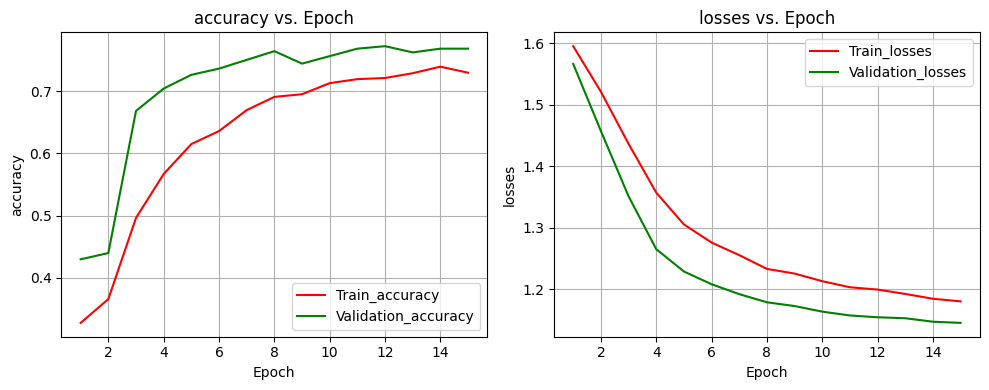

In [ ]:
plot_findings(len(train_accuracies), [[train_accuracies, validation_accuracies], [train_losses, validation_losses]], "Epoch", isoptimal=True)

## Here lies the optimization for most of the hyperparameters and how we derived them


### (b) Different modes (aggregation methods used, and all their accuracies):
also assuming that the other parameters used are constant, for eg batch_size, hidden_dim, etc etc

#### Mean Mode


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 34%|███▍      | 17/50 [00:06<00:13,  2.43it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 7.00 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8360



 36%|███▌      | 18/50 [00:07<00:12,  2.55it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.07 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.8380



 16%|█▌        | 8/50 [00:03<00:17,  2.44it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 3.28 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.8040



 38%|███▊      | 19/50 [00:07<00:12,  2.56it/s]

Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 7.41 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8220



 36%|███▌      | 18/50 [00:07<00:13,  2.38it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.56 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8420


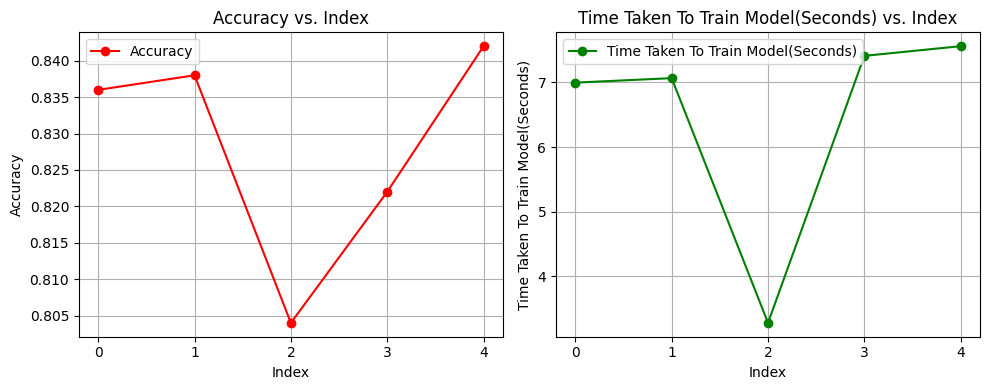

Best accuracy from Mean Runs: 4, 0.842
Average accuracy from Mean Runs: 0.8283999999999999


In [ ]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
mean_run_index = [i for i in range(5)]

for run in mean_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(mean_run_index, [acc, tt], "Index")
print(f"Best accuracy from Mean Runs: {mean_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from Mean Runs: {sum(acc)/len(acc)}")

In [ ]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[1, 0, 3, 2, 2, 1, 2, 2, 3, 0, 2, 0, 4, 4, 3, 0, 2, 3, 3, 2, 4, 3, 3, 4, 1, 2, 2, 2, 3, 0, 0, 4, 2, 2, 3, 4, 3, 4, 4, 2, 2, 3, 4, 4, 2, 3, 3, 1, 2, 0, 0, 3, 0, 2, 3, 4, 3, 2, 4, 2, 2, 4, 4, 2, 2, 3, 2, 2, 3, 4, 4, 3, 2, 1, 2, 1, 3, 2, 2, 4, 4, 2, 1, 4, 4, 2, 2, 0, 4, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 4, 3, 4, 3, 2, 4, 1, 0, 4, 4, 0, 4, 4, 2, 2, 4, 2, 4, 2, 0, 3, 4, 4, 0, 0, 1, 3, 4, 3, 2, 2, 4, 1, 2, 2, 2, 4, 1, 3, 0, 2, 3, 0, 3, 2, 1, 3, 4, 3, 3, 1, 3, 2, 3, 4, 4, 4, 4, 3, 2, 2, 0, 4, 2, 0, 3, 3, 2, 2, 2, 4, 4, 3, 2, 2, 0, 4, 2, 0, 2, 4, 2, 2, 4, 2, 1, 3, 0, 4, 4, 0, 3, 3, 0, 2, 1, 2, 1, 1, 2, 3, 1, 4, 2, 3, 4, 4, 1, 0, 0, 4, 3, 0, 4, 3, 3, 4, 2, 2, 0, 1, 2, 4, 4, 2, 4, 3, 1, 0, 2, 3, 4, 3, 2, 4, 2, 1, 3, 1, 3, 1, 4, 0, 3, 4, 2, 1, 2, 2, 1, 3, 3, 3, 2, 0, 1, 4, 2, 3, 2, 3, 1, 2, 3, 1, 4, 2, 4, 2, 2, 3, 3, 2, 1, 1, 4, 0, 2, 4, 2, 0, 3, 3, 3, 4, 2, 4, 4, 3, 0, 3, 3, 4, 4, 0, 3, 0, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 2, 1, 2, 2, 0, 0, 1, 2, 4, 2, 2, 2, 1, 4, 2, 0, 2, 0, 1, 1, 4, 0, 4, 2, 2, 

#### Max Mode


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 16%|█▌        | 8/50 [00:01<00:08,  4.99it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 1.60 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7280



 18%|█▊        | 9/50 [00:01<00:07,  5.39it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 1.67 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7620



 16%|█▌        | 8/50 [00:01<00:08,  5.07it/s]


Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 1.58 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7240


 22%|██▏       | 11/50 [00:02<00:07,  5.46it/s]


Early stopping at epoch (12) due to no improvement in accuracy.
Time taken for the model to run finish: 2.02 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7200


 18%|█▊        | 9/50 [00:01<00:08,  5.05it/s]


Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 1.78 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7400


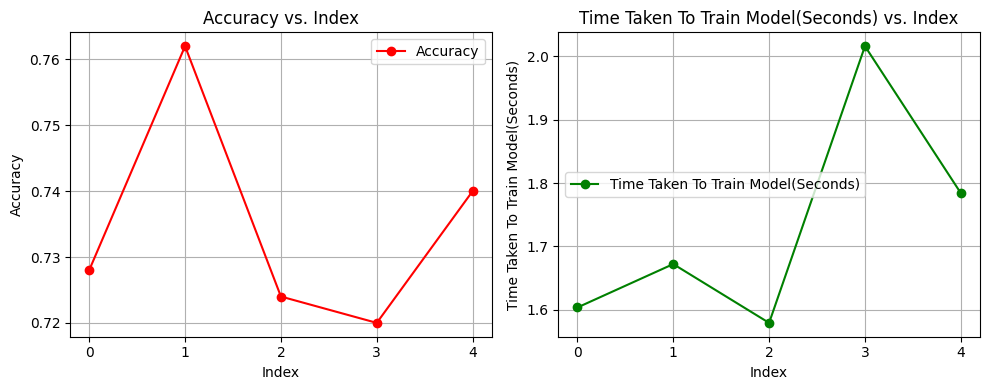

Best accuracy from Max Runs: 1, 0.762
Average accuracy from Max Runs: 0.7348000000000001


In [ ]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "max"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
max_run_index = [i for i in range(5)]

for run in max_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(max_run_index, [acc, tt], "Index")
print(f"Best accuracy from Max Runs: {max_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from Max Runs: {sum(acc)/len(acc)}")

In [ ]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[1, 0, 3, 2, 2, 1, 2, 2, 3, 0, 2, 0, 4, 4, 3, 0, 0, 3, 3, 2, 4, 4, 0, 4, 1, 0, 0, 2, 3, 0, 2, 3, 2, 2, 3, 4, 3, 4, 4, 2, 2, 4, 4, 4, 2, 3, 3, 1, 0, 0, 0, 3, 2, 4, 3, 4, 0, 0, 4, 2, 2, 0, 0, 2, 2, 3, 0, 2, 2, 4, 4, 3, 0, 1, 2, 1, 3, 0, 0, 4, 0, 0, 0, 4, 4, 2, 2, 4, 4, 0, 2, 3, 2, 0, 0, 2, 1, 2, 2, 0, 3, 4, 3, 2, 4, 1, 0, 4, 3, 0, 4, 4, 2, 2, 4, 2, 4, 0, 3, 3, 4, 4, 0, 1, 1, 0, 1, 3, 2, 2, 4, 0, 4, 0, 2, 4, 1, 3, 2, 0, 3, 0, 3, 2, 1, 0, 4, 3, 3, 1, 3, 0, 4, 4, 4, 4, 4, 3, 2, 0, 0, 4, 4, 0, 3, 3, 2, 2, 2, 4, 4, 3, 2, 2, 0, 4, 2, 1, 2, 1, 2, 2, 4, 0, 1, 3, 0, 4, 4, 0, 3, 3, 0, 2, 2, 2, 1, 1, 4, 3, 1, 4, 2, 3, 4, 4, 1, 0, 0, 4, 0, 2, 4, 3, 3, 4, 2, 3, 0, 1, 2, 4, 4, 2, 4, 3, 1, 0, 2, 3, 4, 4, 2, 4, 2, 1, 3, 1, 3, 1, 4, 0, 3, 4, 0, 1, 2, 2, 1, 3, 3, 3, 2, 1, 1, 4, 2, 3, 2, 3, 1, 2, 3, 1, 4, 1, 4, 2, 2, 3, 3, 4, 1, 3, 4, 0, 2, 4, 4, 4, 3, 3, 3, 0, 2, 4, 4, 3, 0, 0, 3, 0, 4, 0, 3, 0, 3, 0, 2, 0, 3, 4, 0, 3, 1, 0, 3, 0, 2, 1, 2, 2, 0, 0, 1, 2, 4, 2, 2, 2, 1, 4, 2, 0, 0, 0, 1, 1, 4, 1, 4, 0, 2, 

#### RNN Mode


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 18%|█▊        | 9/50 [00:03<00:15,  2.58it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 3.49 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1300



 10%|█         | 5/50 [00:02<00:18,  2.50it/s]

Early stopping at epoch (6) due to no improvement in accuracy.
Time taken for the model to run finish: 2.00 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880



 12%|█▏        | 6/50 [00:02<00:17,  2.54it/s]

Early stopping at epoch (7) due to no improvement in accuracy.
Time taken for the model to run finish: 2.37 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880



  6%|▌         | 3/50 [00:01<00:20,  2.34it/s]

Early stopping at epoch (4) due to no improvement in accuracy.
Time taken for the model to run finish: 1.28 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880



  6%|▌         | 3/50 [00:01<00:20,  2.30it/s]

Early stopping at epoch (4) due to no improvement in accuracy.
Time taken for the model to run finish: 1.31 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.1880


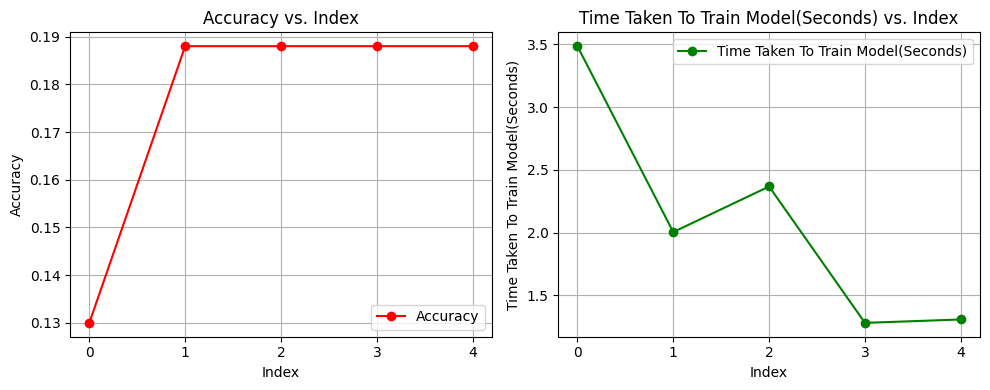

Best accuracy from RNN Runs: 1, 0.188
Average accuracy from RNN Runs: 0.17639999999999997


In [ ]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "rnn"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
rnn_run_index = [i for i in range(5)]

for run in rnn_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(rnn_run_index, [acc, tt], "Index")
print(f"Best accuracy from RNN Runs: {rnn_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from RNN Runs: {sum(acc)/len(acc)}")

In [ ]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

#### RNN Multi

$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 22%|██▏       | 11/50 [00:07<00:26,  1.46it/s]

Early stopping at epoch (12) due to no improvement in accuracy.
Time taken for the model to run finish: 7.53 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.2860



 22%|██▏       | 11/50 [00:07<00:27,  1.43it/s]

Early stopping at epoch (12) due to no improvement in accuracy.
Time taken for the model to run finish: 7.68 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.3980



 20%|██        | 10/50 [00:07<00:28,  1.42it/s]

Early stopping at epoch (11) due to no improvement in accuracy.
Time taken for the model to run finish: 7.03 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4480



 18%|█▊        | 9/50 [00:06<00:29,  1.39it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 6.48 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.3060



 18%|█▊        | 9/50 [00:06<00:30,  1.36it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 6.63 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.3700


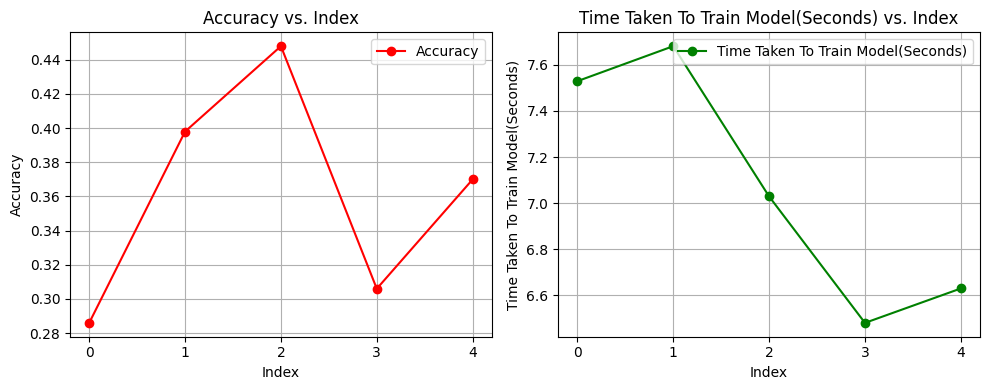

Best accuracy from RNN Multi Runs: 2, 0.448
Average accuracy from RNN Multi Runs: 0.3616


In [ ]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "rnnmulti"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
predicted_labels, actual_labels = [], []
rnn_multi_run_index = [i for i in range(5)]

for run in rnn_multi_run_index:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    predicted_label, actual_label, test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

plot_findings(rnn_multi_run_index, [acc, tt], "Index")
print(f"Best accuracy from RNN Multi Runs: {rnn_multi_run_index[acc.index(max(acc))]}, {max(acc)}")
print(f"Average accuracy from RNN Multi Runs: {sum(acc)/len(acc)}")

In [ ]:
print(predicted_labels[acc.index(max(acc))])
print(actual_labels[acc.index(max(acc))])
print("Predicted labels:",[labels_dict_inverse[i] for i in predicted_labels[acc.index(max(acc))]])
print("Actual labels:   ",[labels_dict_inverse[i] for i in actual_labels[acc.index(max(acc))]])

[1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 4, 1, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 0, 0, 4, 0, 4, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0, 4, 0, 3, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 1, 1, 0, 0, 0, 0, 3, 0, 4, 0, 1, 0, 1, 3, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 4, 0, 0, 1, 3, 3, 0, 0, 4, 4, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 4, 0, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 4, 0, 0, 

### Best score for Batch Size:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 24%|██▍       | 12/50 [00:11<00:35,  1.06it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 11.27 seconds
Time taken to run finish the test: 0.04 seconds
Test Accuracy: 0.8280



 24%|██▍       | 12/50 [00:07<00:22,  1.69it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 7.12 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8320



 34%|███▍      | 17/50 [00:08<00:15,  2.12it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 8.02 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8460



 24%|██▍       | 12/50 [00:04<00:15,  2.43it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 4.95 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8020



 76%|███████▌  | 38/50 [00:12<00:03,  3.01it/s]

Early stopping at epoch (39) due to no improvement in accuracy.
Time taken for the model to run finish: 12.62 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.8460



 16%|█▌        | 8/50 [00:02<00:14,  2.87it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 2.79 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4020


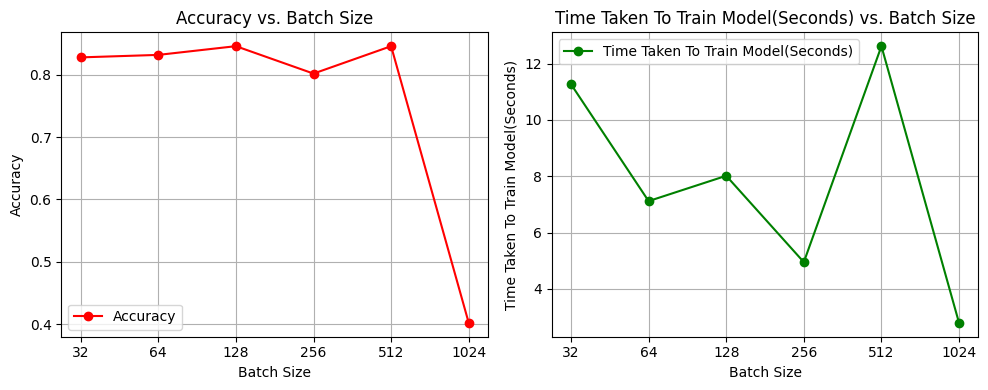

Best accuracy for Batch Size: 128, 0.846


In [ ]:
# batch_size = 32
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
batch_size = [32, 64, 128, 256, 512, 1024]
for BS in batch_size:
    train_data_loader, validation_data_loader = get_training_data(
        BS, w2v, train_df, validation_df)
    test_data_loader = get_test_data(BS, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(batch_size, [acc, tt], "Batch Size")
print(f"Best accuracy for Batch Size: {batch_size[acc.index(max(acc))]}, {max(acc)}")

### Best score for Hidden Dimension:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 46%|████▌     | 23/50 [00:09<00:10,  2.55it/s]

Early stopping at epoch (24) due to no improvement in accuracy.
Time taken for the model to run finish: 9.02 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8240



 24%|██▍       | 12/50 [00:04<00:15,  2.49it/s]


Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 4.82 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8140


 38%|███▊      | 19/50 [00:07<00:12,  2.52it/s]

Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 7.55 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8260



 34%|███▍      | 17/50 [00:07<00:13,  2.37it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 7.19 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8400



 16%|█▌        | 8/50 [00:03<00:19,  2.17it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 3.69 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8300



 14%|█▍        | 7/50 [00:03<00:23,  1.81it/s]

Early stopping at epoch (8) due to no improvement in accuracy.
Time taken for the model to run finish: 3.87 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8300


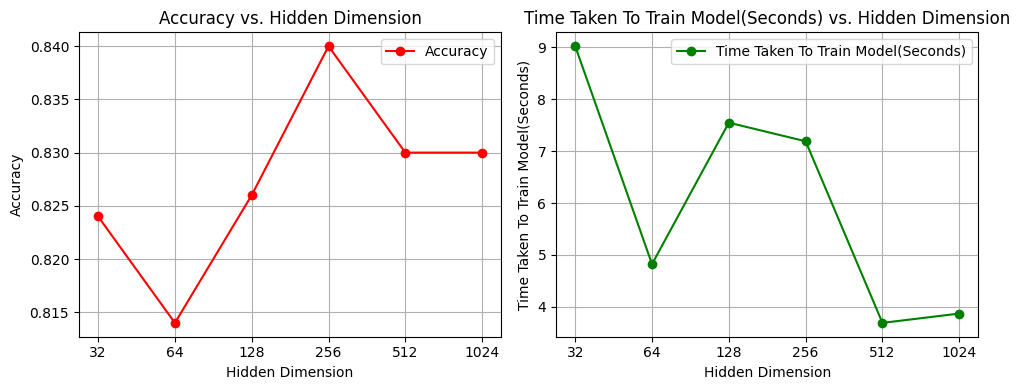

Best accuracy for Hidden Dimension: 256, 0.84


In [ ]:
batch_size = 128
# hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
hidden_dim = [32, 64, 128, 256, 512, 1024]
for HD in hidden_dim:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, HD, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(hidden_dim, [acc, tt], "Hidden Dimension")
print(f"Best accuracy for Hidden Dimension: {hidden_dim[acc.index(max(acc))]}, {max(acc)}")

### Best score for Learning Rate:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 76%|███████▌  | 38/50 [00:15<00:04,  2.49it/s]

Early stopping at epoch (39) due to no improvement in accuracy.
Time taken for the model to run finish: 15.26 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7340



 42%|████▏     | 21/50 [00:08<00:12,  2.39it/s]

Early stopping at epoch (22) due to no improvement in accuracy.
Time taken for the model to run finish: 8.77 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8360



 16%|█▌        | 8/50 [00:03<00:19,  2.17it/s]

Early stopping at epoch (9) due to no improvement in accuracy.
Time taken for the model to run finish: 3.68 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8180



 24%|██▍       | 12/50 [00:05<00:16,  2.35it/s]

Early stopping at epoch (13) due to no improvement in accuracy.
Time taken for the model to run finish: 5.11 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8080



100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


Time taken for the model to run finish: 19.44 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.2760


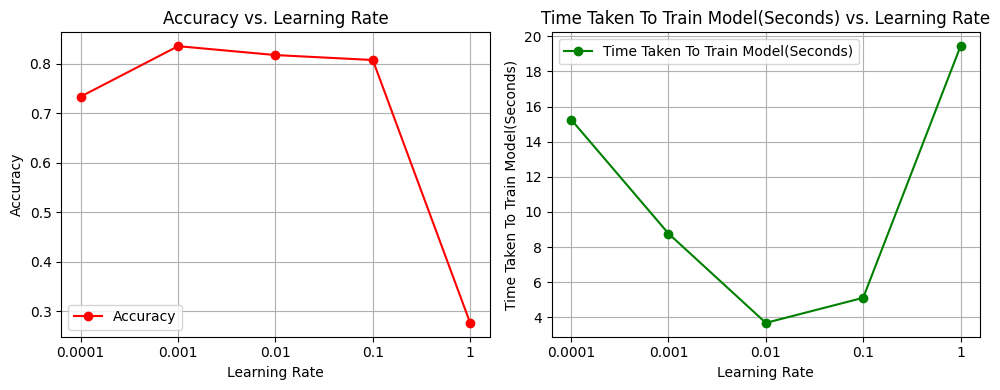

Best accuracy for Learning Rate: 0.001, 0.836


In [ ]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
# learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
for lr in learning_rate:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=lr, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(learning_rate, [acc, tt], "Learning Rate")
print(f"Best accuracy for Learning Rate: {learning_rate[acc.index(max(acc))]}, {max(acc)}")

### Best score for Dropout Probability:


$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 38%|███▊      | 19/50 [00:07<00:12,  2.41it/s]

Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 7.88 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8320



 28%|██▊       | 14/50 [00:05<00:14,  2.52it/s]

Early stopping at epoch (15) due to no improvement in accuracy.
Time taken for the model to run finish: 5.55 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8420



 26%|██▌       | 13/50 [00:05<00:14,  2.50it/s]

Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 5.19 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8220



 36%|███▌      | 18/50 [00:07<00:12,  2.55it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.06 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8320



 26%|██▌       | 13/50 [00:05<00:14,  2.49it/s]

Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 5.22 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8480


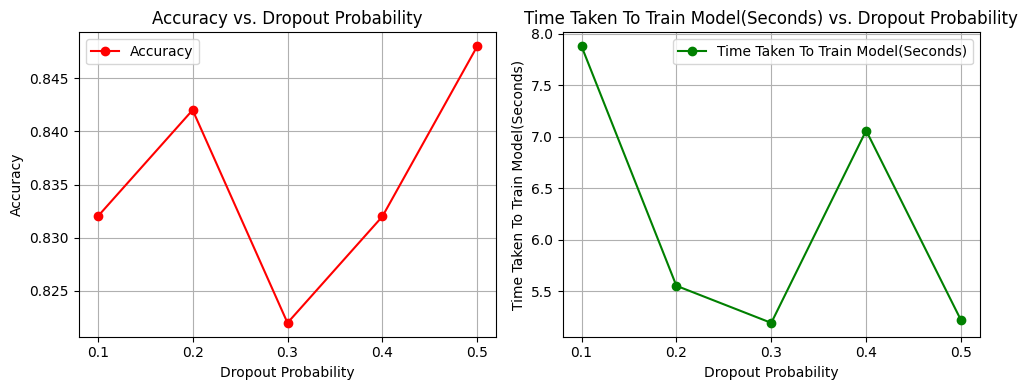

Best accuracy for Dropout Probability: 0.5, 0.848


In [ ]:
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
# dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
dropout_prob = [0.1, 0.2, 0.3, 0.4, 0.5]
for dp in dropout_prob:
    train_data_loader, validation_data_loader = get_training_data(
        batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels,
                      pretrained_embeddings, dropout_prob=dp)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode=mode,
                                         device=device, epochs=epoch, random_initial_state=False,
                                         learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    _, _, test_accuracy = test_model(
        model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(dropout_prob, [acc, tt], "Dropout Probability")
print(f"Best accuracy for Dropout Probability: {dropout_prob[acc.index(max(acc))]}, {max(acc)}")

## Defining a function to process a single sentence from the test df


In [ ]:
def preprocess_sentence(sentence, w2v_model, max_sentence_len):
    # Tokenize the sentence and convert the tokens to their corresponding indices in the word2vec model
    word_to_index = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else 3000000 for word in sentence.split()]

    # Save the actual length of the sentence
    actual_len = len(word_to_index)

    # Pad the tokenized sentence to max_sentence_len
    if len(word_to_index) < max_sentence_len:
        num_padding = max_sentence_len - len(word_to_index)
        word_to_index += [3000000] * num_padding

    # Convert the tokenized sentence to a tensor and add an extra dimension to make it a batch
    sentence_tensor = torch.tensor(word_to_index).unsqueeze(0).to(device)

    return sentence_tensor, torch.tensor([actual_len])

### Optimal Parameter Model

In [ ]:
# # TO FIND OPTIMAL PARAMETERS
batch_size = 128
hidden_dim = 256
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)

model = get_model(embedding_dim, hidden_dim, num_labels,
                  pretrained_embeddings, dropout_prob=dropout_prob)

# Train the model
train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken = train_model(
    model=model, train_data_loader=train_data_loader, validation_data_loader=validation_data_loader,
    mode=mode, device=device, epochs=epoch, random_initial_state=False, learning_rate=learning_rate,
    early_stopper=early_stopper, debug=False)

# Obtain the accuracy of the model using test set
_, _, test_accuracy = test_model(
    model=model, test_data_loader=test_data_loader, mode=mode, device=device)

$ GPU Activated $
[1, 3, 0, 'OTHERS', 4]
{1: 0, 3: 1, 0: 2, 'OTHERS': 3, 4: 4}
Length of num_labels:  5


 30%|███       | 15/50 [00:06<00:16,  2.18it/s]

Early stopping at epoch (16) due to no improvement in accuracy.
Time taken for the model to run finish: 6.88 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.8420


### Testing for a sentence in test.csv


In [ ]:
sentence_index = 3
# Test model on one sentence
sentence = test_df.loc[sentence_index, 'text']
max_sentence_len = max(test_df['text'].apply(lambda x: len(x.split())))
preprocessed_input, sentence_len = preprocess_sentence(sentence, w2v, max_sentence_len)
output = model(preprocessed_input, sentence_len=sentence_len,mode=mode, _device=device)

# Get the predicted label
predicted_label = torch.argmax(output, dim=1)

# Convert the predicted label to its original string form
predicted_label_str = labels_dict_inverse[predicted_label.item()]

print(predicted_label_str)

0


In [ ]:
print(test_df.loc[sentence_index])

label-coarse                    0
label-fine                      7
text            What is an atom ?
Name: 3, dtype: object
